In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

import traj_sim
import utils
import models
import train_cSGM
import coupling_traj_sim as coupling

import __main__

rng = np.random.default_rng()

This notebook is a demonstration of training a conditional SGM on data from a dynamical system described by multiscale SDEs and coupling it with Umbrella Sampling. Consider the following system:
\
\
\begin{equation}
    \begin{split}
        \mbox{d} x_1(t) &= a_1\mbox{d} t + a_2\mbox{d} B_1 \\
        \mbox{d} x_2(t) &= -((1 + x_2(t))^2 (2 (1 + h - k) x_2(t) - 2 h + 3 (0.75 k - 2) x_2(t)^2 \\
            &+ 4 x_2(t)^3) + 2 (1 + x_2(t)) (h - 2 h x_2(t) + (1 + h - k) x_2(t)^2 \\ &+ (0.75 k - 2) x_2(t)^3 + x_2(t)^4))\mbox{d} t + a_3 \mbox{d} B_2(t)
    \end{split}
\end{equation}
\
For more details on the parameters of the SDEs and details behind this notebook and code, refer to https://arxiv.org/abs/2312.05715.

In [2]:
# xs_0 = traj_sim.variable_height_dwell(10000000)
# np.save('./variable_dwell_xs.npy', xs_0)
xs_0 = np.load('./variable_dwell_xs.npy')

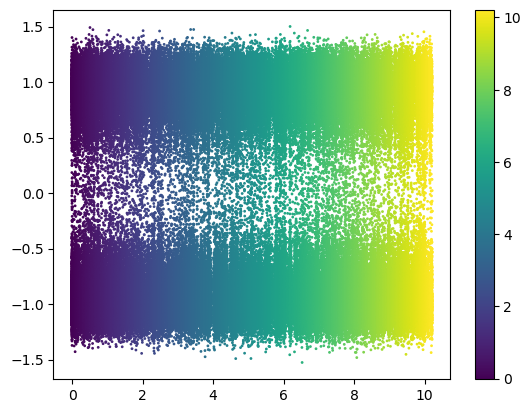

In [3]:
plt.scatter(xs_0[::50, 0], xs_0[::50, 1], c=xs_0[::50, 0], s=1)
#plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
plt.colorbar()
plt.show()

In [4]:
labels = xs_0[::50, 0]
xs = torch.from_numpy(xs_0[::50,:]).cpu()

In [5]:
step_rng = rng
cond_delta = 0.1
N_epochs = 1001
batch_size = 50
model_dir = './saved_models/variable_dwell/'

The above three cells first simulate a long trajectory of the system consisting of 10,000,000 sample points (or alternatively loading in a numpy file that has already been generated from a simulation). Then labeling the data based on the known slow coordinate, $z_1$. We can also label based on an identified diffusion map coordinate (see the related notebook for that demonstration). Then finally, we declare the parameters needed to train the SGM (i.e. the number of epochs, batch size, and cutoff for binning the conditional labels).  

In [6]:
score_model = train_cSGM.train(xs, labels, N_epochs, batch_size, cond_delta, model_dir)

Epoch 0 	, Loss 1.012698 
Epoch 100 	, Loss 0.490298 
Epoch 200 	, Loss 0.452080 
Epoch 300 	, Loss 0.449429 
Epoch 400 	, Loss 0.374634 
Epoch 500 	, Loss 0.305965 
Epoch 600 	, Loss 0.303251 
Epoch 700 	, Loss 0.278642 
Epoch 800 	, Loss 0.381135 
Epoch 900 	, Loss 0.276023 
Epoch 1000 	, Loss 0.235211 


In [7]:
setattr(__main__, "ScoreNet", models.ScoreNet)
score_model2 = torch.load('./saved_models/variable_dwell/global_step_001000.pth')


y = torch.full((500,), 5)
trained_score = lambda x, t: score_model2(x.float(), t.float(), y.int())
samples = utils.reverse_sde(step_rng, 2, 500, utils.drift, utils.diffusivity, trained_score)

Once we train the model, we can generate many points from the SGM conditioned on a label that we prescribe. Here $z_1 = 5$.

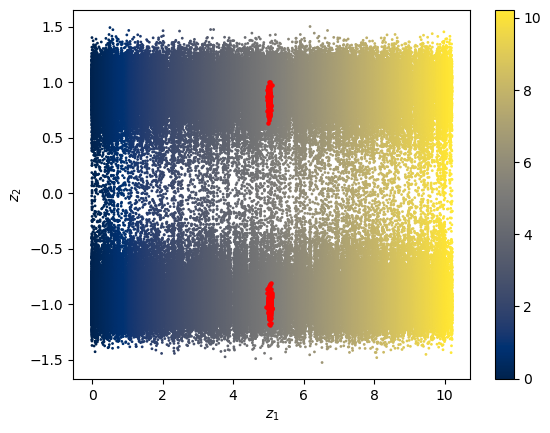

In [8]:
#xs2 = xs[::]
plt.scatter(xs[:,0], xs[:,1], c=labels[::], s=1, cmap='cividis')
plt.colorbar()
plt.scatter(samples[:,0], samples[:,1], color='red', s = 5)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

In [9]:
coupled_trajs_1000, coupled_x2_1000, coupled_norms_1000 = coupling.simulate_coupled_trajs(1000)
coupled_trajs_5000, coupled_x2_5000, coupled_norms_5000 = coupling.simulate_coupled_trajs(5000)

# coupled_trajs_10000, coupled_x2_10000, coupled_norms_10000 = coupling.simulate_coupled_trajs(10000)
# coupled_trajs_50000, coupled_x2_50000, coupled_norms_50000 = coupling.simulate_coupled_trajs(50000)

In [10]:
US_trajs_1000, US_x2_1000, US_norms_1000 = coupling.simulate_US_trajs(1000)
US_trajs_5000, US_x2_5000, US_norms_5000 = coupling.simulate_US_trajs(5000)

# US_trajs_10000, US_x2_10000, US_norms_10000 = coupling.simulate_US_trajs(10000)
# US_trajs_50000, US_x2_50000, US_norms_50000 = coupling.simulate_US_trajs(50000)

In [11]:
results_US_mean = np.array([np.average(US_norms_1000[1:]), np.average(US_norms_5000[1:])])#, np.average(US_norms_10000[1:]), np.average(US_norms_50000[1:])])
results_GAN_plus_US_mean = np.array([np.average(coupled_norms_1000[1:]), np.average(coupled_norms_5000[1:])])#, np.average(coupled_norms_10000[1:]), np.average(coupled_norms_50000[1:])])

results_US_std = np.array([np.std(US_norms_1000[1:]), np.std(US_norms_5000[1:])])#, np.std(US_norms_10000[1:]), np.std(US_norms_50000[1:])])
results_GAN_plus_US_std = np.array([np.std(coupled_norms_1000[1:]), np.std(coupled_norms_5000[1:])])#, np.std(coupled_norms_10000[1:]), np.std(coupled_norms_50000[1:])])

<ErrorbarContainer object of 3 artists>

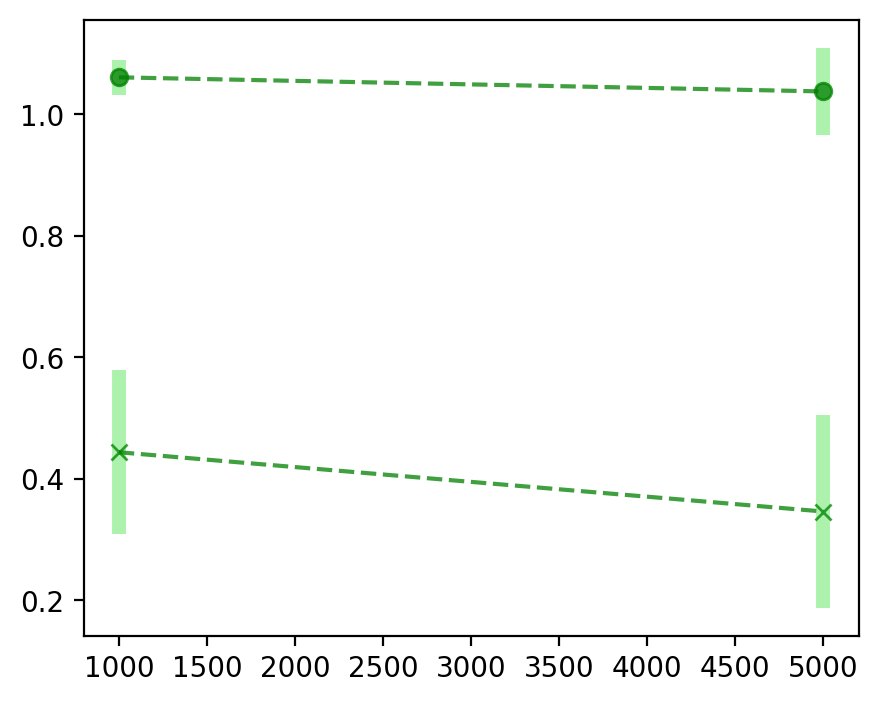

In [12]:
sample_sizes = np.array([1000, 5000])#, 10000, 50000, 100000, 500000])
plt.figure(figsize=(5, 4), dpi=200)
plt.errorbar(sample_sizes, results_US_mean[:], results_US_std[:], label='US', fmt='o--', color='green', ecolor='lightgreen', elinewidth=5, capsize=0, alpha=0.75)
plt.errorbar(sample_sizes, results_GAN_plus_US_mean[:], results_GAN_plus_US_std[:], label='SGM+US', fmt='x--', color='green', ecolor='lightgreen', elinewidth=5, capsize=0, alpha=0.75)